## Load sub

The videos are in the order of Experiment_id, so not in the order of presentation. This means the first video is the same for each participant.

In [2]:
import pickle
import numpy as np
import gc  # Garbage collector

!pip install mrmr-selection
!pip install ordpy

In [3]:
participants = 32
subjects = {'data': [], 'labels': []}
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'

# Read and collect data
for i in range(1, participants + 1):
    file_name = prefix_path + f"data_preprocessed_python\\s{'0' if i < 10 else ''}{i}.dat"
    with open(file_name, 'rb') as file:
        subject = pickle.load(file, encoding='latin1')
        for key in subjects:
            subjects[key].append(subject[key])

        del subject

# Merge data and reshape
for key in subjects:
    subjects[key] = np.concatenate(subjects[key], axis=0)

print(subjects['data'].shape)
print(subjects['labels'].shape)

(1280, 40, 8064)
(1280, 4)


In [4]:
# Use 2 classifiers valence and arousal
subjects['labels'] = subjects['labels'][:, :2]

# Use threshold 5 to assign binary label to each classifier
subjects['labels'][:, 0] = (subjects['labels'][:, 0] >= 5).astype(int)
subjects['labels'][:, 1] = (subjects['labels'][:, 1] >= 5).astype(int)

print(set(subjects['labels'][:, 0]))
print(set(subjects['labels'][:, 1]))

{np.float64(0.0), np.float64(1.0)}
{np.float64(0.0), np.float64(1.0)}


## Split Train Test Dataset

In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    subjects['data'], subjects['labels'], test_size=test_size, random_state=random_state
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

del subjects
gc.collect()  # Free up memory

(1024, 40, 8064) (256, 40, 8064) (1024, 2) (256, 2)


476

## Feature extraction


### Wavelet transform

In [6]:
# Wavelet transform
import pywt
from tqdm import tqdm

# Sampling frequency:
fs = 128

# Select scales and wavelets
scales = np.arange(1, 129)  # Example: 129 scale values
wavelet = 'morl'

def CWT_for_sample(data):
    cwt_output = []
    # Calculate CWT for each sample and each channel
    for i in tqdm(range(data.shape[0])):  # 1024 samples
        cwt_channels = []
        for j in range(data.shape[1]):  # 40 channels
            coeffs, freqs = pywt.cwt(data[i, j], scales, wavelet) # coeffs are of the form (len(scales), 8064)
            energy_scales = np.sum(np.abs(coeffs)**2, axis=1)  # (len(scales),)
            cwt_channels.append(energy_scales)
        cwt_output.append(cwt_channels)
    
    # Convert output to numpy array
    cwt_output = np.array(cwt_output)  # Size: (1024, 40, len(scales))

    return cwt_output
    
# cwt_train = CWT_for_sample(X_train) # Size: (1024, 40, len(scales))
# cwt_test = CWT_for_sample(X_test) # Size: (256, 40, len(scales))

# print(cwt_train.shape, cwt_test.shape)

# # Save file name
# prefix_output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
# filename = "cwt_data.pkl"

# # Save data
# with open(prefix_output_path +filename, 'wb') as file:
#     pickle.dump({'train': cwt_train, 'test': cwt_test}, file)

# print(f"Data has been saved to file {filename}")


In [7]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "cwt_data.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    data = pickle.load(file)

# Data retrieval
cwt_train_loaded = data['train']
cwt_test_loaded = data['test']

print("Size cwt_train:", cwt_train_loaded.shape)
print("Size cwt_test:", cwt_test_loaded.shape)


Size cwt_train: (1024, 40, 128)
Size cwt_test: (256, 40, 128)


### Nonlinear Feature Analyses: Permutation Entropy

In [8]:
import ordpy

def split_array(arr, num_epochs):
    
    len_arr = len(arr)
    len_epochs = round(len_arr / num_epochs)
    
    splits_arr = [arr[i * len_epochs: len_arr if i + 1 == num_epochs else (i + 1) * len_epochs] for i in range(num_epochs)]

    return splits_arr

def permutation_entropy_eeg(data, num_epochs=8):
    B, C, T = data.shape
    pe = np.zeros((B, C, num_epochs))
    
    for b in tqdm(range(B)):
        for c in range(C):
            splits_arr = split_array(data[b, c], num_epochs)
            for i in range(num_epochs):
                pe[b, c, i] = ordpy.permutation_entropy(splits_arr[i])

    return pe

# pe_train = permutation_entropy_eeg(X_train)#1024x40
# pe_test = permutation_entropy_eeg(X_test)#256x40

# # Save file name
# prefix_output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
# filename = "pe_data.pkl"

# # Save data
# with open(prefix_output_path + filename, 'wb') as file:
#    pickle.dump({'train': pe_train, 'test': pe_test}, file)

# print(f"Data has been saved to file {filename}")

In [9]:
# # Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "pe_data.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    data = pickle.load(file)

# Data retrieval
pe_train_loaded = data['train']
pe_test_loaded = data['test']

print("Size pe_train:", pe_train_loaded.shape)
print("Size pe_test:", pe_test_loaded.shape)

Size pe_train: (1024, 40, 8)
Size pe_test: (256, 40, 8)


## Feature Selection

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import pickle

DEVICE = 'cpu' 

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, rnn_type="LSTM", device=DEVICE):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        # Choose the RNN type (LSTM or GRU)
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type. Use 'LSTM' or 'GRU'.")

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, feature_extraction=False):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Reshape if necessary
        if len(x.shape) == 2:
            x = x.view(batch_size, seq_len, self.input_size)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) if isinstance(self.rnn, nn.LSTM) else None

        # Pass through the RNN
        out, (hn, cn) = self.rnn(x, (h0, c0)) if isinstance(self.rnn, nn.LSTM) else self.rnn(x, h0)

        if feature_extraction:
            return out

        # Take the last hidden state
        out = out[:, -1, :]

        # Output layer
        out = self.fc(out)
        return out


class CNNModel(nn.Module):
    def __init__(self, in_channels, outs_channels, output_size, length_signal, device=DEVICE):
        super().__init__()

        channels = [in_channels] + outs_channels
        self.model = nn.Sequential(
            *[nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, device=device),
                nn.BatchNorm1d(out_channels, device=device),
                nn.ReLU()
            ) for in_channels, out_channels in zip(channels[:-1], channels[1:]) ]
        )

        self.fc = nn.Linear(outs_channels[-1] * length_signal, output_size, device=device) 

    def forward(self, x, feature_extraction=False):
        x = self.model(x)

        if feature_extraction:
            # If we want feature extraction, return features before the fully connected layer
            return x

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.squeeze()

        return x


def pca_data(data, k):
    # Reshape the data into (n_samples, n_features) to prepare for PCA
    n_samples, n_channels, n_features = data.shape
    data_reshaped = data.reshape(n_samples * n_channels, n_features)
    
    # Data Normalization
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_reshaped)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=k)
    data_pca = pca.fit_transform(data_scaled)
    
    # Reshape back to (n_samples, n_channels, k)
    data_pca_reshaped = data_pca.reshape(n_samples, n_channels, k)
    
    return data_pca_reshaped


def feature_extraction_with_rnn_cnn(X, y, model_type="CNN", k=128):
    """
    Extract features from the RNN or CNN model and return the extracted features.
    
    Args:
        X (numpy.ndarray): The input data (n_samples, n_channels, n_features).
        y (numpy.ndarray): The labels (n_samples, num_classes).
        model_type (str): The model to use for feature extraction, either "RNN" or "CNN".
        k (int): Number of principal components to keep after PCA.

    Returns:
        extracted_features (numpy.ndarray): The extracted features from the model.
    """
    # Apply PCA
    pca_data_transformed = pca_data(X, k=k)

    # Convert to tensor
    pca_data_tensor = torch.Tensor(pca_data_transformed).to(DEVICE)
    
    # Reshape the data to have 1 channel instead of 40
    pca_data_tensor = pca_data_tensor.reshape(pca_data_tensor.shape[0], 1, pca_data_tensor.shape[1] * pca_data_tensor.shape[2])

    # Choose model
    if model_type == "CNN":
        model = CNNModel(in_channels=1, outs_channels=[32, 64], output_size=10, length_signal=k, device=DEVICE)
    elif model_type == "RNN":
        model = RNNModel(input_size=5120, hidden_size=128, num_layers=2, output_size=10, device=DEVICE)
    else:
        raise ValueError("Model type must be either 'RNN' or 'CNN'.")

    # Extract features using the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        extracted_features = model(pca_data_tensor, feature_extraction=True)  # Extract features

    return extracted_features


# Assuming you have X_train, y_train, X_test, and y_test already loaded

# Select model type based on input
model_type = "RNN" 

# Feature extraction for train and test sets
if model_type == "CNN":
    features_train = feature_extraction_with_rnn_cnn(X_train, y_train, model_type="CNN", k=128)
    features_test = feature_extraction_with_rnn_cnn(X_test, y_test, model_type="CNN", k=128)
elif model_type == "RNN":
    features_train = feature_extraction_with_rnn_cnn(X_train, y_train, model_type="RNN", k=128)
    features_test = feature_extraction_with_rnn_cnn(X_test, y_test, model_type="RNN", k=128)

# Save the extracted features to a pickle file
output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = f"pca_data_train_test_{model_type.lower()}.pkl"  # File name will include model type

with open(output_path + filename, 'wb') as file:
    pickle.dump({
        'train': features_train,
        'test': features_test
    }, file)

print(f"Data has been saved to file {output_path + filename}")


Data has been saved to file C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\pca_data_train_test_rnn.pkl


In [11]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
if model_type == "CNN":
    filename = "pca_data_train_test_cnn.pkl"
elif model_type == "RNN":
    filename = "pca_data_train_test_rnn.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    data = pickle.load(file)
    
# print(data)

# Data retrieval
pca_train_loaded = data['train']
pca_test_loaded = data['test']

print("Size pca_train:", pca_train_loaded.shape)
print("Size pca_test:", pca_test_loaded.shape)

Size pca_train: torch.Size([1024, 1, 128])
Size pca_test: torch.Size([256, 1, 128])


In [11]:
from mrmr import mrmr_classif
import pandas as pd

def feature_selector(num_features, X, y, classif_obj): # keep last dimension
    flatted_X = X.reshape(-1, X.shape[-1])

    flatted_X = pd.DataFrame(flatted_X)

    flatted_y_new = y
    if len(y.shape) == 2:
        y_new = np.repeat(y[:, np.newaxis, :], X.shape[1], axis=1)
        flatted_y_new = y_new.reshape(-1, y_new.shape[-1])
        
    flatted_y_new = flatted_y_new[:,classif_obj]

    selected_features = mrmr_classif(X=flatted_X, y=flatted_y_new, K=num_features)

    return selected_features

f = feature_selector(64, cwt_train_loaded, y_train, 0)
feature_selections = {
    'PCA': {
        'Valence': feature_selector(64, pca_train_loaded, y_train, 0), #1024x40x8064
        'Arousal': feature_selector(64, pca_train_loaded, y_train, 1) #1024x40x8064
    },
    'WT': {
        'Valence': feature_selector(64, cwt_train_loaded, y_train, 0), #1024x40x128
        'Arousal': feature_selector(64, cwt_train_loaded, y_train, 1) #1024x40x128
    }
}

# Save file name
prefix_output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "feature_selections.pkl"

# Save data
with open(prefix_output_path + filename, 'wb') as file:
    pickle.dump(feature_selections, file)

print(f"Data has been saved to file {filename}")

100%|██████████| 64/64 [00:13<00:00,  4.67it/s]

Data has been saved to file feature_selections.pkl


In [12]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "feature_selections.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    feature_selection_loaded = pickle.load(file)

print(feature_selection_loaded)

{'PCA': {'Valence': [np.int64(117), np.int64(67), np.int64(42), np.int64(4), np.int64(44), np.int64(111), np.int64(81), np.int64(119), np.int64(99), np.int64(14), np.int64(54), np.int64(110), np.int64(45), np.int64(87), np.int64(48), np.int64(38), np.int64(40), np.int64(66), np.int64(98), np.int64(76), np.int64(70), np.int64(94), np.int64(2), np.int64(118), np.int64(28), np.int64(9), np.int64(121), np.int64(24), np.int64(125), np.int64(47), np.int64(23), np.int64(51), np.int64(95), np.int64(61), np.int64(30), np.int64(75), np.int64(101), np.int64(39), np.int64(29), np.int64(52), np.int64(22), np.int64(68), np.int64(57), np.int64(79), np.int64(7), np.int64(90), np.int64(6), np.int64(59), np.int64(127), np.int64(37), np.int64(97), np.int64(25), np.int64(73), np.int64(77), np.int64(85), np.int64(0), np.int64(36), np.int64(93), np.int64(113), np.int64(108), np.int64(62), np.int64(104), np.int64(5), np.int64(17)], 'Arousal': [np.int64(76), np.int64(1), np.int64(15), np.int64(123), np.int64(

## Data synthesis

In [13]:
aggregated_data = [
    ['WT', 'YES', 'VALENCE', {'TRAIN': (cwt_train_loaded[:, :, feature_selection_loaded['WT']['Valence']], y_train), 
                              'TEST': (cwt_test_loaded[:, :, feature_selection_loaded['WT']['Valence']], y_test)}],
    ['WT', 'YES', 'AROUSAL', {'TRAIN': (cwt_train_loaded[:, :, feature_selection_loaded['WT']['Arousal']], y_train),
                              'TEST': (cwt_test_loaded[:, :, feature_selection_loaded['WT']['Arousal']], y_test)}],

    ['WT', 'NO', '*', {'TRAIN': (cwt_train_loaded, y_train), 
                       'TEST': (cwt_test_loaded, y_test)}],

    ['PE', 'NO', '*', {'TRAIN': (pe_train_loaded, y_train), 
                       'TEST': (pe_test_loaded, y_test)}],

    ['NONE', 'YES', 'VALENCE', {'TRAIN': (pca_train_loaded[:, :, feature_selection_loaded['PCA']['Valence']], y_train), 
                                'TEST': (pca_test_loaded[:, :, feature_selection_loaded['PCA']['Valence']], y_test)}],
    ['NONE', 'YES', 'AROUSAL', {'TRAIN': (pca_train_loaded[:, :, feature_selection_loaded['PCA']['Arousal']], y_train), 
                                'TEST': (pca_test_loaded[:, :, feature_selection_loaded['PCA']['Arousal']], y_test)}],

    ['NONE', 'NO', '*', {'TRAIN': (pca_train_loaded, y_train), 
                         'TEST': (pca_test_loaded, y_test)}],
]

## Model

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_metric(metric, y_true, y_pred):
    """
    Calculates the value of a metric based on the input metric name.

    Args:
        metric (str): Metric name, one of the ['Acc', 'Sens', 'Spec', 'Prec', 'F-measure'].
        y_true (array-like): Actual label.
        y_pred (array-like): Predictive label.

    Returns:
        float: Value of selected metric.

    Raises:
        ValueError: If the metric is not in the supported list.
    """
    metric = metric.lower()  # Convert metrics to lowercase for easier handling

    if metric == 'acc':
        return accuracy_score(y_true, y_pred)
    elif metric == 'sens':  # Sensitivity (Recall)
        return recall_score(y_true, y_pred, average='binary')
    elif metric == 'spec':  # Specificity
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp) if (tn + fp) != 0 else 0.0
    elif metric == 'prec':  # Precision
        return precision_score(y_true, y_pred, average='binary')
    elif metric == 'f-measure':  # F1-Score
        return f1_score(y_true, y_pred, average='binary')
    else:
        raise ValueError(f"Metric '{metric}' not supported. Please select one of the ['Acc', 'Sens', 'Spec', 'Prec', 'F-measure'].")
    

def evaluate(model, name_model, classifi_obj, X, y):
    """
    Evaluate the model on the provided data.

    Args:
        model: The trained model.
        name_model: The type of model ('rnn', 'cnn', etc.)
        classifi_obj: Whether it's a classification problem (True/False).
        X: Input data.
        y: True labels.

    Returns:
        dict: Metrics like accuracy, sensitivity, specificity, etc.
    """
    if name_model == 'rnn' or name_model == 'cnn':
        # Handle PyTorch models (RNN, CNN, etc.)
        model.eval()  # Set model to evaluation mode if it's a PyTorch model

        if classifi_obj:
            X = X.permute(0, 2, 1)  # Assuming the model expects input (batch_size, seq_len, feature_dim)
        
        with torch.no_grad():
            y_pred = model(X)  # PyTorch models are callable
            y_pred = F.sigmoid(y_pred) >= 0.5  # For binary classification (change if necessary)
            y_pred = y_pred.float().cpu().numpy()

    else:
        # Handle scikit-learn models (RandomForest, etc.)
        # If the model is not a PyTorch model, reshape the input to 2D (n_samples, n_features)
        n_samples, n_channels, n_features = X.shape
        X_reshaped = X.reshape(n_samples, n_channels * n_features)  # Flatten the channels and features
        
        y_pred = model.predict(X_reshaped)  # Use the `predict` method for scikit-learn models
        y_pred = y_pred.astype(float)  # Ensure the output is a float for metric calculations

    # Convert y_true to a 1D array if it's multilabel-indicator
    if len(y.shape) > 1 and y.shape[1] > 1:  # Check if y_true is multilabel (e.g., one-hot encoded)
        y = np.argmax(y, axis=1)  # Convert to class labels

    # Calculate metrics (accuracy, precision, etc.)
    result = {
        "Acc": calculate_metric("Acc", y, y_pred),
        "Sens": calculate_metric("Sens", y, y_pred),
        "Spec": calculate_metric("Spec", y, y_pred),
        "Prec": calculate_metric("Prec", y, y_pred),
        "F-measure": calculate_metric("F-measure", y, y_pred),
    }

    return result

In [16]:
def setup_config_train_ml_model(X_train, y_train, X_test, y_test, name_model):
    return {
        'X_train': X_train,
        'y_train': y_train,
        'name_model': name_model.lower()
    }

def train_ml_model(model, classifi_obj, **kwargs):
    name_model = kwargs.get('name_model').lower()
    X_train = kwargs.get('X_train')
    X_train = X_train.reshape(X_train.shape[0], -1)
    y = kwargs.get('y_train')[:, classifi_obj]
    model.fit(X_train, y)

def setup_config_train(X_train, y_train, X_test, y_test, name_model):
    name_model = name_model.lower()
    return setup_config_train_ml_model(X_train, y_train, X_test, y_test, name_model)

def train_model(model, classifi_obj, **kwargs):
    if kwargs.get('name_model').lower() in ['svm', 'rf', 'lr', 'knn', 'gb', 'xgboost', 'adaboost', 'dt']:

        return train_ml_model(model, classifi_obj, **kwargs)
    

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

def get_model(**kwargs):
    model = None
    name_model = kwargs.get('name_model').lower()
    
    device = kwargs.get('device', DEVICE)
    
    if name_model == 'svm':
        model = SVC(kernel='rbf')
        
    elif name_model == 'rf':
        model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42)

    elif name_model == 'lr':
        model = LogisticRegression(max_iter=1000, random_state=42)

    elif name_model == 'knn':
        model = KNeighborsClassifier(n_neighbors=5)

    elif name_model == 'dt':
        model = DecisionTreeClassifier(max_depth=10, random_state=42)

    else:
        raise ValueError(f"Model {name_model} not recognized. Please choose from 'svm', 'rf', 'lr', 'knn', 'gb', 'xgboost', 'adaboost', 'dt'.")
    
    return model


In [18]:
models = []
evaluates = []
i = 0
for name_model in ['rf', 'svm', 'lr', 'knn', 'dt']:
    for experiment in aggregated_data:
        data = experiment[-1]
        classifi_objs = [0] if experiment[2] == 'VALENCE' else [1] if experiment[2] == 'AROUSAL' else [0,1]
        (X_train_data, y_train_data), (X_test_data, y_test_data) = data['TRAIN'], data['TEST']
        # print(X_test_data.shape, X_train_data.shape)
        for classifi_obj in classifi_objs:
            config = {
                'length_signal': X_train_data.shape[-1],
                'name_model': name_model
            }
            
            model = get_model(**config)

            # print(name_model)
            config_train = setup_config_train(X_train_data, y_train_data, X_test_data, y_test_data, name_model)
            train_model(model, classifi_obj, **config_train)

            motion = 'VALENCE' if classifi_obj else 'AROUSAL'

            models.append((*experiment[:2], motion, model))

            info = (
                name_model,
                *experiment[:2], 
                motion,
                evaluate(model, name_model, classifi_obj, X_test_data, y_test_data)['Acc']*100
            )
            i += 1
            print(f'experiment {i}: {info}')
            evaluates.append(info)
            
            

experiment 1: ('rf', 'WT', 'YES', 'AROUSAL', 73.828125)
experiment 2: ('rf', 'WT', 'YES', 'VALENCE', 78.90625)
experiment 3: ('rf', 'WT', 'NO', 'AROUSAL', 74.21875)
experiment 4: ('rf', 'WT', 'NO', 'VALENCE', 77.734375)
experiment 5: ('rf', 'PE', 'NO', 'AROUSAL', 78.125)
experiment 6: ('rf', 'PE', 'NO', 'VALENCE', 78.515625)
experiment 7: ('rf', 'NONE', 'YES', 'AROUSAL', 78.515625)
experiment 8: ('rf', 'NONE', 'YES', 'VALENCE', 78.515625)
experiment 9: ('rf', 'NONE', 'NO', 'AROUSAL', 78.515625)
experiment 10: ('rf', 'NONE', 'NO', 'VALENCE', 78.515625)
experiment 11: ('svm', 'WT', 'YES', 'AROUSAL', 77.734375)
experiment 12: ('svm', 'WT', 'YES', 'VALENCE', 78.515625)
experiment 13: ('svm', 'WT', 'NO', 'AROUSAL', 77.734375)
experiment 14: ('svm', 'WT', 'NO', 'VALENCE', 78.515625)
experiment 15: ('svm', 'PE', 'NO', 'AROUSAL', 78.515625)
experiment 16: ('svm', 'PE', 'NO', 'VALENCE', 78.515625)
experiment 17: ('svm', 'NONE', 'YES', 'AROUSAL', 78.515625)
experiment 18: ('svm', 'NONE', 'YES', 

In [19]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import pickle

DEVICE = 'cpu' 

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, rnn_type="GRU", device=DEVICE):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        # Choose the RNN type (LSTM or GRU)
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type. Use 'LSTM' or 'GRU'.")

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, feature_extraction=False):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Reshape if necessary
        if len(x.shape) == 2:
            x = x.view(batch_size, seq_len, self.input_size)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) if isinstance(self.rnn, nn.LSTM) else None

        # Pass through the RNN
        out, (hn, cn) = self.rnn(x, (h0, c0)) if isinstance(self.rnn, nn.LSTM) else self.rnn(x, h0)

        if feature_extraction:
            return out

        # Take the last hidden state
        out = out[:, -1, :]

        # Output layer
        out = self.fc(out)
        return out


class CNNModel(nn.Module):
    def __init__(self, in_channels, outs_channels, output_size, length_signal, device=DEVICE):
        super().__init__()

        channels = [in_channels] + outs_channels
        self.model = nn.Sequential(
            *[nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, device=device),
                nn.BatchNorm1d(out_channels, device=device),
                nn.ReLU()
            ) for in_channels, out_channels in zip(channels[:-1], channels[1:]) ]
        )

        self.fc = nn.Linear(outs_channels[-1] * length_signal, output_size, device=device) 

    def forward(self, x, feature_extraction=False):
        x = self.model(x)

        if feature_extraction:
            # If we want feature extraction, return features before the fully connected layer
            return x

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.squeeze()

        return x


def pca_data(data, k):
    # Reshape the data into (n_samples, n_features) to prepare for PCA
    n_samples, n_channels, n_features = data.shape
    data_reshaped = data.reshape(n_samples * n_channels, n_features)
    
    # Data Normalization
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_reshaped)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=k)
    data_pca = pca.fit_transform(data_scaled)
    
    # Reshape back to (n_samples, n_channels, k)
    data_pca_reshaped = data_pca.reshape(n_samples, n_channels, k)
    
    return data_pca_reshaped


def feature_extraction_with_rnn_cnn(X, y, model_type="CNN", k=128):
    """
    Extract features from the RNN or CNN model and return the extracted features.
    
    Args:
        X (numpy.ndarray): The input data (n_samples, n_channels, n_features).
        y (numpy.ndarray): The labels (n_samples, num_classes).
        model_type (str): The model to use for feature extraction, either "RNN" or "CNN".
        k (int): Number of principal components to keep after PCA.

    Returns:
        extracted_features (numpy.ndarray): The extracted features from the model.
    """
    # Apply PCA
    pca_data_transformed = pca_data(X, k=k)

    # Convert to tensor
    pca_data_tensor = torch.Tensor(pca_data_transformed).to(DEVICE)
    
    # Reshape the data to have 1 channel instead of 40
    pca_data_tensor = pca_data_tensor.reshape(pca_data_tensor.shape[0], 1, pca_data_tensor.shape[1] * pca_data_tensor.shape[2])

    # Choose model
    if model_type == "CNN":
        model = CNNModel(in_channels=1, outs_channels=[32, 64], output_size=10, length_signal=k, device=DEVICE)
    elif model_type == "RNN":
        model = RNNModel(input_size=5120, hidden_size=128, num_layers=2, output_size=10, device=DEVICE)
    else:
        raise ValueError("Model type must be either 'RNN' or 'CNN'.")

    # Extract features using the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        extracted_features = model(pca_data_tensor, feature_extraction=True)  # Extract features

    return extracted_features


# Assuming you have X_train, y_train, X_test, and y_test already loaded

# Select model type based on input
model_type = "RNN" 

# Feature extraction for train and test sets
if model_type == "CNN":
    features_train = feature_extraction_with_rnn_cnn(X_train, y_train, model_type="CNN", k=128)
    features_test = feature_extraction_with_rnn_cnn(X_test, y_test, model_type="CNN", k=128)
elif model_type == "RNN":
    features_train = feature_extraction_with_rnn_cnn(X_train, y_train, model_type="RNN", k=128)
    features_test = feature_extraction_with_rnn_cnn(X_test, y_test, model_type="RNN", k=128)

# Save the extracted features to a pickle file
output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = f"pca_data_train_test_{model_type.lower()}.pkl"  # File name will include model type

with open(output_path + filename, 'wb') as file:
    pickle.dump({
        'train': features_train,
        'test': features_test
    }, file)

print(f"Data has been saved to file {output_path + filename}")


Data has been saved to file C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\pca_data_train_test_rnn.pkl


In [20]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
if model_type == "CNN":
    filename = "pca_data_train_test_cnn.pkl"
elif model_type == "RNN":
    filename = "pca_data_train_test_rnn.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    data = pickle.load(file)
    
# print(data)

# Data retrieval
pca_train_loaded = data['train']
pca_test_loaded = data['test']

print("Size pca_train:", pca_train_loaded.shape)
print("Size pca_test:", pca_test_loaded.shape)

Size pca_train: torch.Size([1024, 1, 128])
Size pca_test: torch.Size([256, 1, 128])


In [21]:
from mrmr import mrmr_classif
import pandas as pd

def feature_selector(num_features, X, y, classif_obj): # keep last dimension
    flatted_X = X.reshape(-1, X.shape[-1])

    flatted_X = pd.DataFrame(flatted_X)

    flatted_y_new = y
    if len(y.shape) == 2:
        y_new = np.repeat(y[:, np.newaxis, :], X.shape[1], axis=1)
        flatted_y_new = y_new.reshape(-1, y_new.shape[-1])
        
    flatted_y_new = flatted_y_new[:,classif_obj]

    selected_features = mrmr_classif(X=flatted_X, y=flatted_y_new, K=num_features)

    return selected_features

f = feature_selector(64, cwt_train_loaded, y_train, 0)
feature_selections = {
    'PCA': {
        'Valence': feature_selector(64, pca_train_loaded, y_train, 0), #1024x40x8064
        'Arousal': feature_selector(64, pca_train_loaded, y_train, 1) #1024x40x8064
    },
    'WT': {
        'Valence': feature_selector(64, cwt_train_loaded, y_train, 0), #1024x40x128
        'Arousal': feature_selector(64, cwt_train_loaded, y_train, 1) #1024x40x128
    }
}

# Save file name
prefix_output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "feature_selections.pkl"

# Save data
with open(prefix_output_path + filename, 'wb') as file:
    pickle.dump(feature_selections, file)

print(f"Data has been saved to file {filename}")

100%|██████████| 64/64 [00:13<00:00,  4.64it/s]

Data has been saved to file feature_selections.pkl


In [22]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "feature_selections.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    feature_selection_loaded = pickle.load(file)

print(feature_selection_loaded)

{'PCA': {'Valence': [np.int64(45), np.int64(124), np.int64(36), np.int64(17), np.int64(56), np.int64(79), np.int64(12), np.int64(32), np.int64(102), np.int64(26), np.int64(63), np.int64(66), np.int64(105), np.int64(58), np.int64(70), np.int64(127), np.int64(117), np.int64(59), np.int64(103), np.int64(89), np.int64(65), np.int64(106), np.int64(107), np.int64(72), np.int64(48), np.int64(86), np.int64(0), np.int64(51), np.int64(74), np.int64(55), np.int64(90), np.int64(119), np.int64(52), np.int64(10), np.int64(88), np.int64(97), np.int64(104), np.int64(29), np.int64(123), np.int64(2), np.int64(116), np.int64(101), np.int64(62), np.int64(64), np.int64(35), np.int64(5), np.int64(85), np.int64(38), np.int64(99), np.int64(31), np.int64(113), np.int64(19), np.int64(118), np.int64(120), np.int64(71), np.int64(11), np.int64(109), np.int64(1), np.int64(95), np.int64(28), np.int64(81), np.int64(100), np.int64(77), np.int64(40)], 'Arousal': [np.int64(32), np.int64(69), np.int64(34), np.int64(109),

In [23]:
aggregated_data = [
    ['WT', 'YES', 'VALENCE', {'TRAIN': (cwt_train_loaded[:, :, feature_selection_loaded['WT']['Valence']], y_train), 
                              'TEST': (cwt_test_loaded[:, :, feature_selection_loaded['WT']['Valence']], y_test)}],
    ['WT', 'YES', 'AROUSAL', {'TRAIN': (cwt_train_loaded[:, :, feature_selection_loaded['WT']['Arousal']], y_train),
                              'TEST': (cwt_test_loaded[:, :, feature_selection_loaded['WT']['Arousal']], y_test)}],

    ['WT', 'NO', '*', {'TRAIN': (cwt_train_loaded, y_train), 
                       'TEST': (cwt_test_loaded, y_test)}],

    ['PE', 'NO', '*', {'TRAIN': (pe_train_loaded, y_train), 
                       'TEST': (pe_test_loaded, y_test)}],

    ['NONE', 'YES', 'VALENCE', {'TRAIN': (pca_train_loaded[:, :, feature_selection_loaded['PCA']['Valence']], y_train), 
                                'TEST': (pca_test_loaded[:, :, feature_selection_loaded['PCA']['Valence']], y_test)}],
    ['NONE', 'YES', 'AROUSAL', {'TRAIN': (pca_train_loaded[:, :, feature_selection_loaded['PCA']['Arousal']], y_train), 
                                'TEST': (pca_test_loaded[:, :, feature_selection_loaded['PCA']['Arousal']], y_test)}],

    ['NONE', 'NO', '*', {'TRAIN': (pca_train_loaded, y_train), 
                         'TEST': (pca_test_loaded, y_test)}],
]

In [24]:
models = []
evaluates = []
i = 0
for name_model in ['rf', 'svm', 'lr', 'knn', 'dt']:
    for experiment in aggregated_data:
        data = experiment[-1]
        classifi_objs = [0] if experiment[2] == 'VALENCE' else [1] if experiment[2] == 'AROUSAL' else [0,1]
        (X_train_data, y_train_data), (X_test_data, y_test_data) = data['TRAIN'], data['TEST']
        # print(X_test_data.shape, X_train_data.shape)
        for classifi_obj in classifi_objs:
            config = {
                'length_signal': X_train_data.shape[-1],
                'name_model': name_model
            }
            
            model = get_model(**config)

            # print(name_model)
            config_train = setup_config_train(X_train_data, y_train_data, X_test_data, y_test_data, name_model)
            train_model(model, classifi_obj, **config_train)

            motion = 'VALENCE' if classifi_obj else 'AROUSAL'

            models.append((*experiment[:2], motion, model))

            info = (
                name_model,
                *experiment[:2], 
                motion,
                evaluate(model, name_model, classifi_obj, X_test_data, y_test_data)['Acc']*100
            )
            i += 1
            print(f'experiment {i}: {info}')
            evaluates.append(info)
            
            

experiment 1: ('rf', 'WT', 'YES', 'AROUSAL', 73.828125)
experiment 2: ('rf', 'WT', 'YES', 'VALENCE', 78.90625)
experiment 3: ('rf', 'WT', 'NO', 'AROUSAL', 74.21875)
experiment 4: ('rf', 'WT', 'NO', 'VALENCE', 77.734375)
experiment 5: ('rf', 'PE', 'NO', 'AROUSAL', 78.125)
experiment 6: ('rf', 'PE', 'NO', 'VALENCE', 78.515625)
experiment 7: ('rf', 'NONE', 'YES', 'AROUSAL', 78.515625)
experiment 8: ('rf', 'NONE', 'YES', 'VALENCE', 78.515625)
experiment 9: ('rf', 'NONE', 'NO', 'AROUSAL', 78.515625)
experiment 10: ('rf', 'NONE', 'NO', 'VALENCE', 78.515625)
experiment 11: ('svm', 'WT', 'YES', 'AROUSAL', 77.734375)
experiment 12: ('svm', 'WT', 'YES', 'VALENCE', 78.515625)
experiment 13: ('svm', 'WT', 'NO', 'AROUSAL', 77.734375)
experiment 14: ('svm', 'WT', 'NO', 'VALENCE', 78.515625)
experiment 15: ('svm', 'PE', 'NO', 'AROUSAL', 78.515625)
experiment 16: ('svm', 'PE', 'NO', 'VALENCE', 78.515625)
experiment 17: ('svm', 'NONE', 'YES', 'AROUSAL', 78.515625)
experiment 18: ('svm', 'NONE', 'YES', 

In [25]:
# Select model type based on input
model_type = "CNN" 

# Feature extraction for train and test sets
if model_type == "CNN":
    features_train = feature_extraction_with_rnn_cnn(X_train, y_train, model_type="CNN", k=128)
    features_test = feature_extraction_with_rnn_cnn(X_test, y_test, model_type="CNN", k=128)
elif model_type == "RNN":
    features_train = feature_extraction_with_rnn_cnn(X_train, y_train, model_type="RNN", k=128)
    features_test = feature_extraction_with_rnn_cnn(X_test, y_test, model_type="RNN", k=128)

# Save the extracted features to a pickle file
output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = f"pca_data_train_test_{model_type.lower()}.pkl"  # File name will include model type

with open(output_path + filename, 'wb') as file:
    pickle.dump({
        'train': features_train,
        'test': features_test
    }, file)

print(f"Data has been saved to file {output_path + filename}")

Data has been saved to file C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\deap-dataset\pca_data_train_test_cnn.pkl


In [26]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
if model_type == "CNN":
    filename = "pca_data_train_test_cnn.pkl"
elif model_type == "RNN":
    filename = "pca_data_train_test_rnn.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    data = pickle.load(file)
    
# print(data)

# Data retrieval
pca_train_loaded = data['train']
pca_test_loaded = data['test']

print("Size pca_train:", pca_train_loaded.shape)
print("Size pca_test:", pca_test_loaded.shape)

Size pca_train: torch.Size([1024, 64, 5120])
Size pca_test: torch.Size([256, 64, 5120])


In [27]:
from mrmr import mrmr_classif
import pandas as pd

def feature_selector(num_features, X, y, classif_obj): # keep last dimension
    flatted_X = X.reshape(-1, X.shape[-1])

    flatted_X = pd.DataFrame(flatted_X)

    flatted_y_new = y
    if len(y.shape) == 2:
        y_new = np.repeat(y[:, np.newaxis, :], X.shape[1], axis=1)
        flatted_y_new = y_new.reshape(-1, y_new.shape[-1])
        
    flatted_y_new = flatted_y_new[:,classif_obj]

    selected_features = mrmr_classif(X=flatted_X, y=flatted_y_new, K=num_features)

    return selected_features

f = feature_selector(64, cwt_train_loaded, y_train, 0)
feature_selections = {
    'PCA': {
        'Valence': feature_selector(64, pca_train_loaded, y_train, 0), #1024x40x8064
        'Arousal': feature_selector(64, pca_train_loaded, y_train, 1) #1024x40x8064
    },
    'WT': {
        'Valence': feature_selector(64, cwt_train_loaded, y_train, 0), #1024x40x128
        'Arousal': feature_selector(64, cwt_train_loaded, y_train, 1) #1024x40x128
    }
}

# Save file name
prefix_output_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "feature_selections.pkl"

# Save data
with open(prefix_output_path + filename, 'wb') as file:
    pickle.dump(feature_selections, file)

print(f"Data has been saved to file {filename}")

100%|██████████| 64/64 [00:13<00:00,  4.62it/s]

Data has been saved to file feature_selections.pkl


In [28]:
# Save file name
prefix_path = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\deap-dataset\\'
filename = "feature_selections.pkl"

# Read data again
with open(prefix_path + filename, 'rb') as file:
    feature_selection_loaded = pickle.load(file)

print(feature_selection_loaded)

{'PCA': {'Valence': [np.int64(4867), np.int64(4606), np.int64(4892), np.int64(4890), np.int64(4894), np.int64(4893), np.int64(4895), np.int64(4868), np.int64(4896), np.int64(4891), np.int64(4869), np.int64(4903), np.int64(4889), np.int64(4884), np.int64(4756), np.int64(4899), np.int64(4883), np.int64(4898), np.int64(4878), np.int64(4902), np.int64(4871), np.int64(4879), np.int64(4901), np.int64(4870), np.int64(4945), np.int64(4877), np.int64(4897), np.int64(4900), np.int64(4876), np.int64(4748), np.int64(4872), np.int64(4880), np.int64(4881), np.int64(4882), np.int64(4887), np.int64(4994), np.int64(4885), np.int64(4752), np.int64(4904), np.int64(4886), np.int64(4888), np.int64(4607), np.int64(4866), np.int64(4875), np.int64(4749), np.int64(4947), np.int64(4873), np.int64(4757), np.int64(4874), np.int64(4944), np.int64(4758), np.int64(4995), np.int64(4822), np.int64(4913), np.int64(4823), np.int64(4948), np.int64(4768), np.int64(4911), np.int64(4750), np.int64(4912), np.int64(4781), np.

In [29]:
aggregated_data = [
    ['WT', 'YES', 'VALENCE', {'TRAIN': (cwt_train_loaded[:, :, feature_selection_loaded['WT']['Valence']], y_train), 
                              'TEST': (cwt_test_loaded[:, :, feature_selection_loaded['WT']['Valence']], y_test)}],
    ['WT', 'YES', 'AROUSAL', {'TRAIN': (cwt_train_loaded[:, :, feature_selection_loaded['WT']['Arousal']], y_train),
                              'TEST': (cwt_test_loaded[:, :, feature_selection_loaded['WT']['Arousal']], y_test)}],

    ['WT', 'NO', '*', {'TRAIN': (cwt_train_loaded, y_train), 
                       'TEST': (cwt_test_loaded, y_test)}],

    ['PE', 'NO', '*', {'TRAIN': (pe_train_loaded, y_train), 
                       'TEST': (pe_test_loaded, y_test)}],

    ['NONE', 'YES', 'VALENCE', {'TRAIN': (pca_train_loaded[:, :, feature_selection_loaded['PCA']['Valence']], y_train), 
                                'TEST': (pca_test_loaded[:, :, feature_selection_loaded['PCA']['Valence']], y_test)}],
    ['NONE', 'YES', 'AROUSAL', {'TRAIN': (pca_train_loaded[:, :, feature_selection_loaded['PCA']['Arousal']], y_train), 
                                'TEST': (pca_test_loaded[:, :, feature_selection_loaded['PCA']['Arousal']], y_test)}],

    ['NONE', 'NO', '*', {'TRAIN': (pca_train_loaded, y_train), 
                         'TEST': (pca_test_loaded, y_test)}],
]

In [30]:
models = []
evaluates = []
i = 0
for name_model in ['rf', 'svm', 'lr', 'knn', 'dt']:
    for experiment in aggregated_data:
        data = experiment[-1]
        classifi_objs = [0] if experiment[2] == 'VALENCE' else [1] if experiment[2] == 'AROUSAL' else [0,1]
        (X_train_data, y_train_data), (X_test_data, y_test_data) = data['TRAIN'], data['TEST']
        # print(X_test_data.shape, X_train_data.shape)
        for classifi_obj in classifi_objs:
            config = {
                'length_signal': X_train_data.shape[-1],
                'name_model': name_model
            }
            
            model = get_model(**config)

            # print(name_model)
            config_train = setup_config_train(X_train_data, y_train_data, X_test_data, y_test_data, name_model)
            train_model(model, classifi_obj, **config_train)

            motion = 'VALENCE' if classifi_obj else 'AROUSAL'

            models.append((*experiment[:2], motion, model))

            info = (
                name_model,
                *experiment[:2], 
                motion,
                evaluate(model, name_model, classifi_obj, X_test_data, y_test_data)['Acc']*100
            )
            i += 1
            print(f'experiment {i}: {info}')
            evaluates.append(info)
            
            

experiment 1: ('rf', 'WT', 'YES', 'AROUSAL', 73.828125)
experiment 2: ('rf', 'WT', 'YES', 'VALENCE', 78.90625)
experiment 3: ('rf', 'WT', 'NO', 'AROUSAL', 74.21875)
experiment 4: ('rf', 'WT', 'NO', 'VALENCE', 77.734375)
experiment 5: ('rf', 'PE', 'NO', 'AROUSAL', 78.125)
experiment 6: ('rf', 'PE', 'NO', 'VALENCE', 78.515625)
experiment 7: ('rf', 'NONE', 'YES', 'AROUSAL', 69.140625)
experiment 8: ('rf', 'NONE', 'YES', 'VALENCE', 78.90625)
experiment 9: ('rf', 'NONE', 'NO', 'AROUSAL', 78.515625)
experiment 10: ('rf', 'NONE', 'NO', 'VALENCE', 22.65625)
experiment 11: ('svm', 'WT', 'YES', 'AROUSAL', 77.734375)
experiment 12: ('svm', 'WT', 'YES', 'VALENCE', 78.515625)
experiment 13: ('svm', 'WT', 'NO', 'AROUSAL', 77.734375)
experiment 14: ('svm', 'WT', 'NO', 'VALENCE', 78.515625)
experiment 15: ('svm', 'PE', 'NO', 'AROUSAL', 78.515625)
experiment 16: ('svm', 'PE', 'NO', 'VALENCE', 78.515625)
experiment 17: ('svm', 'NONE', 'YES', 'AROUSAL', 78.515625)
experiment 18: ('svm', 'NONE', 'YES', 'V

# **Summary of Best Scores and Configurations**

## **Best Scores for Each Model:**

| Model      | Classifier | Feature Set | Feature Selection | Task   | Accuracy (%) |
|------------|-----------|-------------|-------------------|--------|-------------|
| **RNN LSTM** | SVM       | NONE        | YES               | AROUSAL | **78.5156** |
| **RNN LSTM** | SVM       | NONE        | YES               | VALENCE | **78.5156** |
| **RNN GRU**  | SVM       | NONE        | YES               | AROUSAL | **78.5156** |
| **RNN GRU**  | SVM       | NONE        | YES               | VALENCE | **78.5156** |
| **CNN**      | RF        | WT          | YES               | VALENCE | **78.9063** |

---

## **Best Configurations per Model Type:**

### **RNN LSTM:**
- **Best Score:** **78.5156%**
- **Best Configuration:**  
  - Classifier: **SVM**
  - Feature Set: **NONE**
  - Feature Selection: **YES**
  - Works best for both **Arousal and Valence**

### **RNN GRU:**
- **Best Score:** **78.5156%**
- **Best Configuration:**  
  - Classifier: **SVM**
  - Feature Set: **NONE**
  - Feature Selection: **YES**
  - Works best for both **Arousal and Valence**

### **CNN:**
- **Best Score:** **78.9063%** (Highest overall)
- **Best Configuration:**  
  - Classifier: **Random Forest (RF)**
  - Feature Set: **WT**
  - Feature Selection: **YES**
  - Works best for **Valence**

---

## **Key Takeaways:**
- **Best overall performance is achieved by CNN with RF classifier (78.9063% for Valence).**
- **SVM performs best for RNN models, especially with no predefined feature set (NONE) and Feature Selection (YES).**
- **Feature Selection ("YES") appears to contribute to higher accuracy.**
- **Feature Set "NONE" (no predefined features) seems to work well for RNN models.**
- **Random Forest (RF) is the top performer for CNN.**


## Define/Prepare Data for Exploration, Balancing, and Selection (DEAP CWT Example)


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Configuration ---
FEATURE_SET_TO_ANALYZE = 'CWT' # Options: 'CWT', 'PE', 'PCA_RNN', 'PCA_CNN'
TASK_TO_ANALYZE = 'Valence' # Options: 'Valence', 'Arousal'

# --- Select Data Based on Configuration ---
print(f"Preparing data for Feature Set: {FEATURE_SET_TO_ANALYZE}, Task: {TASK_TO_ANALYZE}")

if FEATURE_SET_TO_ANALYZE == 'CWT':
    # Ensure CWT data is loaded
    if 'cwt_train_loaded' not in locals() or 'cwt_test_loaded' not in locals():
        raise NameError("CWT features (cwt_train_loaded, cwt_test_loaded) not found. Please load them first.")
    X_train_orig_shape = cwt_train_loaded
    X_test_orig_shape = cwt_test_loaded
    print(f"Using CWT features. Original shapes: Train={X_train_orig_shape.shape}, Test={X_test_orig_shape.shape}")
elif FEATURE_SET_TO_ANALYZE == 'PE':
    # Ensure PE data is loaded
    if 'pe_train_loaded' not in locals() or 'pe_test_loaded' not in locals():
        raise NameError("PE features (pe_train_loaded, pe_test_loaded) not found. Please load them first.")
    X_train_orig_shape = pe_train_loaded
    X_test_orig_shape = pe_test_loaded
    print(f"Using PE features. Original shapes: Train={X_train_orig_shape.shape}, Test={X_test_orig_shape.shape}")
elif FEATURE_SET_TO_ANALYZE == 'PCA_RNN' or FEATURE_SET_TO_ANALYZE == 'PCA_CNN':
     # Ensure PCA-Deep features are loaded (assuming they are named pca_train_loaded etc)
    if 'pca_train_loaded' not in locals() or 'pca_test_loaded' not in locals():
        raise NameError(f"PCA-Deep features (pca_train_loaded, pca_test_loaded) not found. Please load them first (ensure model_type matches).")
    # Note: PCA features might already be somewhat processed. Shape might be (N, 1, F) or (N, F)
    X_train_orig_shape = pca_train_loaded.numpy() if isinstance(pca_train_loaded, torch.Tensor) else pca_train_loaded
    X_test_orig_shape = pca_test_loaded.numpy() if isinstance(pca_test_loaded, torch.Tensor) else pca_test_loaded
    print(f"Using PCA+{FEATURE_SET_TO_ANALYZE.split('_')[1]} features. Original shapes: Train={X_train_orig_shape.shape}, Test={X_test_orig_shape.shape}")
    # Handle potential extra dimension from PyTorch models
    if X_train_orig_shape.ndim == 3 and X_train_orig_shape.shape[1] == 1:
         X_train_orig_shape = X_train_orig_shape.squeeze(1)
         X_test_orig_shape = X_test_orig_shape.squeeze(1)
         print(f"Squeezed shapes: Train={X_train_orig_shape.shape}, Test={X_test_orig_shape.shape}")
else:
    raise ValueError("Invalid FEATURE_SET_TO_ANALYZE selected.")


# --- Reshape Features to (n_samples, n_features) ---
# For CWT/PE: (n_samples, n_channels, n_features_per_channel) -> (n_samples, n_channels * n_features_per_channel)
# For PCA+Deep: Should already be closer, potentially (n_samples, n_features) after squeeze
if X_train_orig_shape.ndim == 3:
    n_samples_train = X_train_orig_shape.shape[0]
    n_samples_test = X_test_orig_shape.shape[0]
    X_train_reshaped = X_train_orig_shape.reshape(n_samples_train, -1)
    X_test_reshaped = X_test_orig_shape.reshape(n_samples_test, -1)
    print(f"Reshaped feature dimensions: Train={X_train_reshaped.shape}, Test={X_test_reshaped.shape}")
elif X_train_orig_shape.ndim == 2:
     X_train_reshaped = X_train_orig_shape
     X_test_reshaped = X_test_orig_shape
     print(f"Features already seem 2D: Train={X_train_reshaped.shape}, Test={X_test_reshaped.shape}")
else:
     raise ValueError(f"Unexpected number of dimensions in feature data: {X_train_orig_shape.ndim}")

# --- Select Target Labels ---
# Ensure y_train and y_test exist from the initial split
if 'y_train' not in locals() or 'y_test' not in locals():
    raise NameError("Original labels (y_train, y_test) not found. Please run the train/test split cell.")

if TASK_TO_ANALYZE == 'Valence':
    task_index = 0
elif TASK_TO_ANALYZE == 'Arousal':
    task_index = 1
else:
    raise ValueError("Invalid TASK_TO_ANALYZE selected.")

y_train_task = y_train[:, task_index]
y_test_task = y_test[:, task_index]
print(f"Selected '{TASK_TO_ANALYZE}' labels. Shapes: Train={y_train_task.shape}, Test={y_test_task.shape}")


# --- Define Feature Names (Generic for Reshaped Data) ---
n_features_total = X_train_reshaped.shape[1]
# Create generic names like F0, F1, ... FN
feature_names_generic = [f'F{i}' for i in range(n_features_total)]
# Or create more specific names if possible (example for CWT)
# if FEATURE_SET_TO_ANALYZE == 'CWT' and X_train_orig_shape.ndim == 3:
#    n_channels = X_train_orig_shape.shape[1]
#    n_scales = X_train_orig_shape.shape[2]
#    feature_names_generic = [f'Ch{ch}_Scale{sc}' for ch in range(n_channels) for sc in range(n_scales)]


# --- Apply Scaling (StandardScaler) ---
# Scaling is often crucial for exploration (variance, correlation) and required by many models/techniques
print("\nApplying StandardScaler to the reshaped features...")
scaler_deap = StandardScaler()
X_train_scaled = scaler_deap.fit_transform(X_train_reshaped)
X_test_scaled = scaler_deap.transform(X_test_reshaped) # Use the SAME scaler fitted on train

print("Scaling complete.")
print(f"Scaled Train shape: {X_train_scaled.shape}, Scaled Test shape: {X_test_scaled.shape}")


# --- Final variables for subsequent cells ---
X_train_proc = X_train_scaled
X_test_proc = X_test_scaled
y_train_proc = y_train_task
y_test_proc = y_test_task
feature_names_proc = feature_names_generic # Use the generic names for the scaled data

print("\n--- Prerequisite variables defined for DEAP analysis ---")
print(f"X_train_proc shape: {X_train_proc.shape}")
print(f"X_test_proc shape: {X_test_proc.shape}")
print(f"y_train_proc shape: {y_train_proc.shape}")
print(f"y_test_proc shape: {y_test_proc.shape}")
print(f"Number of feature names: {len(feature_names_proc)}")
print("------------------------------------------------------")

Preparing data for Feature Set: CWT, Task: Valence
Using CWT features. Original shapes: Train=(1024, 40, 128), Test=(256, 40, 128)
Reshaped feature dimensions: Train=(1024, 5120), Test=(256, 5120)
Selected 'Valence' labels. Shapes: Train=(1024,), Test=(256,)

Applying StandardScaler to the reshaped features...
Scaling complete.
Scaled Train shape: (1024, 5120), Scaled Test shape: (256, 5120)

--- Prerequisite variables defined for DEAP analysis ---
X_train_proc shape: (1024, 5120)
X_test_proc shape: (256, 5120)
y_train_proc shape: (1024,)
y_test_proc shape: (256,)
Number of feature names: 5120
------------------------------------------------------


## Feature Exploration (DEAP - CWT Example)

Feature DataFrame Head (DEAP Example):
         F0        F1        F2        F3        F4
0 -0.288573 -0.240898 -0.278889 -0.312778 -0.350022
1 -0.236071 -0.211089 -0.219653 -0.253686 -0.291413
2 -0.326975 -0.287939 -0.320869 -0.349512 -0.362240
3 -0.307907 -0.270272 -0.300056 -0.321871 -0.325774
4 -0.189357 -0.169261 -0.190142 -0.156157 -0.146031

Basic Statistics of Features (DEAP Example - First 5):
                 F0            F1            F2            F3            F4
count  1.024000e+03  1.024000e+03  1.024000e+03  1.024000e+03  1.024000e+03
mean  -1.856154e-16  1.361758e-16 -2.346214e-16  4.328135e-16  1.600282e-16
std    1.000489e+00  1.000489e+00  1.000489e+00  1.000489e+00  1.000489e+00
min   -3.654664e-01 -3.142432e-01 -3.543618e-01 -3.964609e-01 -4.552442e-01
25%   -3.141986e-01 -2.724854e-01 -3.052828e-01 -3.384117e-01 -3.646743e-01
50%   -2.463070e-01 -2.169294e-01 -2.459528e-01 -2.606638e-01 -2.714913e-01
75%   -9.190639e-02 -9.249127e-02 -1.136143e-01 -8.858868e-02

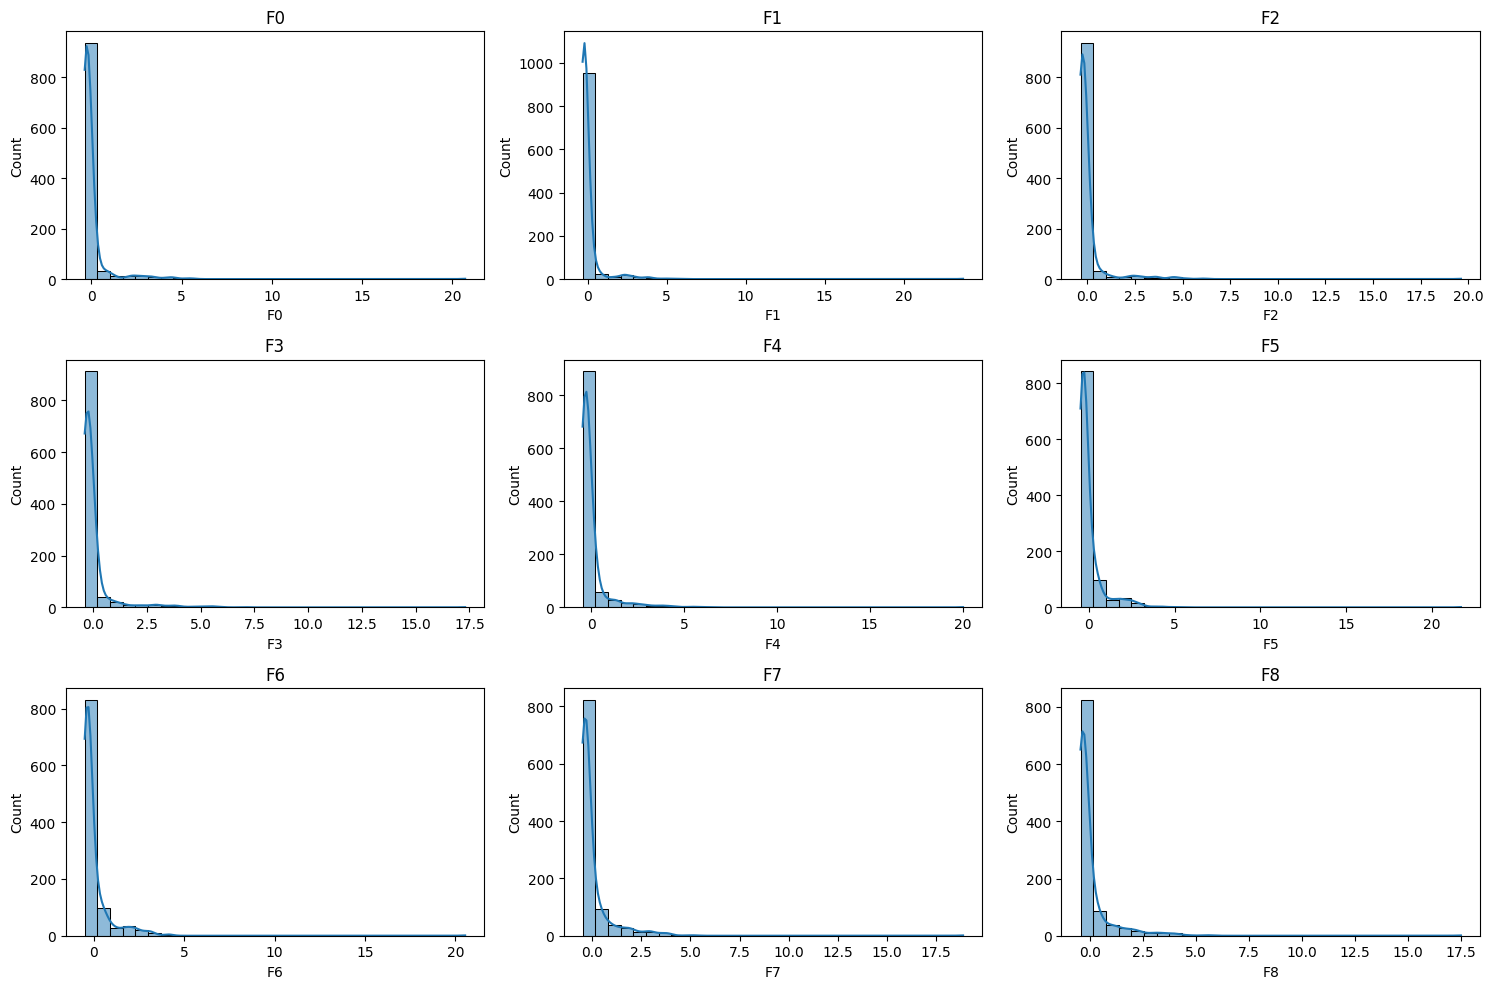


Calculating Feature Correlation Matrix (DEAP Example)...
Correlation matrix shape: (5120, 5120)

Visualizing Feature Correlation Matrix (Subset: First 50 Features)...


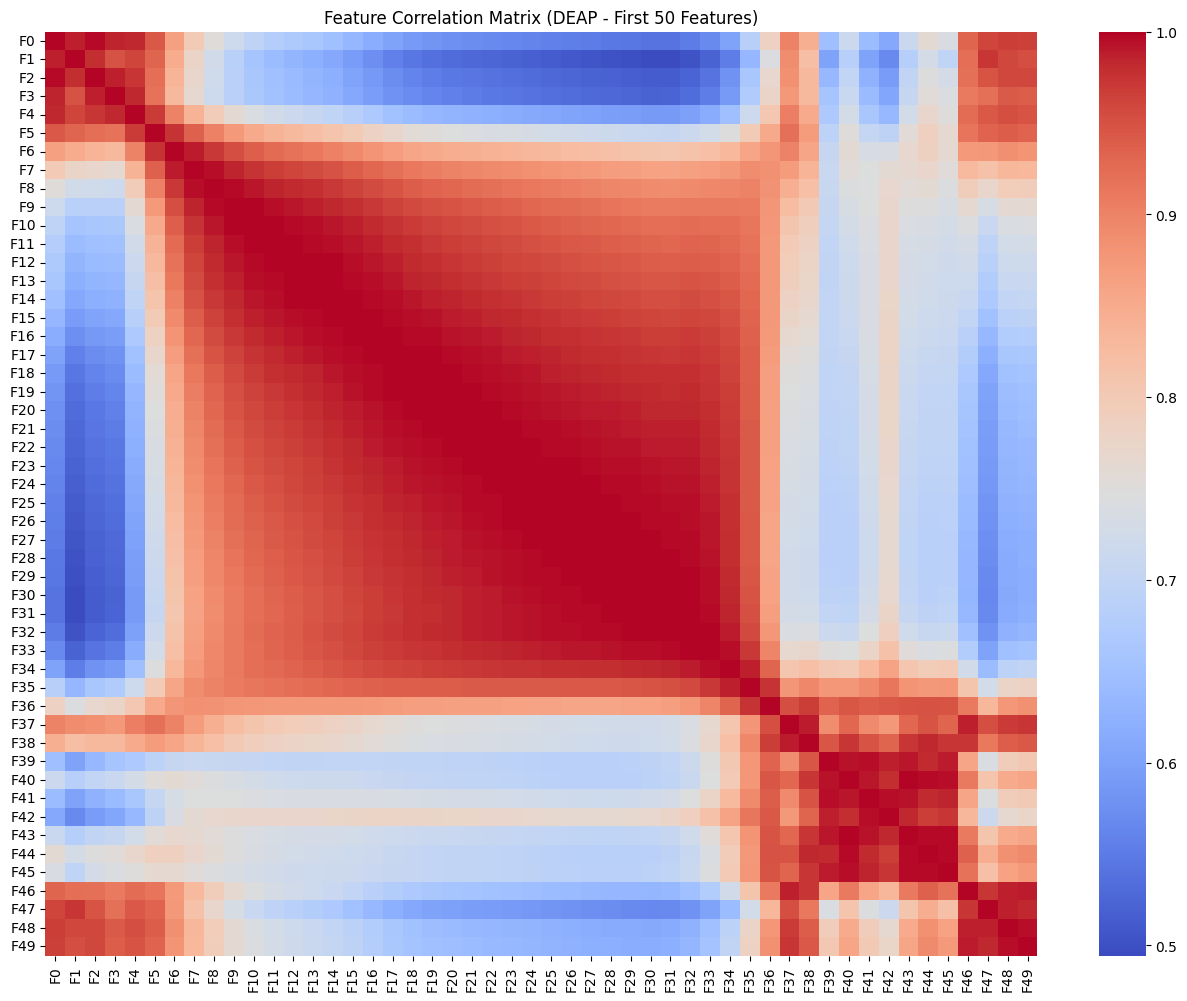


Identifying Highly Correlated Feature Pairs (Threshold > 0.95)...

Found 377999 Highly Correlated Feature Pairs (Threshold > 0.95). Examples:
F4630  F4631    1.0
F5100  F5099    1.0
F4631  F4632    1.0
F5094  F5093    1.0
F4629  F4628    1.0
F4581  F4582    1.0
F4629  F4630    1.0
F4626  F4627    1.0
F4587  F4588    1.0
F4632  F4633    1.0
dtype: float64


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

# --- Use the prepared variables ---
# X_train_proc, X_test_proc, y_train_proc, y_test_proc, feature_names_proc
# are assumed to be available from the previous cell.

# --- Convert to DataFrame for easier exploration ---
# Using the scaled training data
X_train_df_deap = pd.DataFrame(X_train_proc, columns=feature_names_proc)
print("Feature DataFrame Head (DEAP Example):")
# Displaying head might be too wide if many features, consider showing subset
print(X_train_df_deap.iloc[:, :5].head()) # Show head of first 5 features
print("\nBasic Statistics of Features (DEAP Example - First 5):")
print(X_train_df_deap.iloc[:, :5].describe())

# --- Check for Zero Variance Features ---
# Threshold might need adjustment depending on data specifics after scaling
var_thresh_deap = VarianceThreshold(threshold=0.01)
try:
    var_thresh_deap.fit(X_train_proc)
    low_variance_cols_deap = X_train_df_deap.columns[~var_thresh_deap.get_support()]
    if len(low_variance_cols_deap) > 0:
        print(f"\nFeatures with low variance (threshold=0.01): {len(low_variance_cols_deap)} features. Example: {list(low_variance_cols_deap[:10])}") # Show first 10
    else:
        print("\nNo features found with variance below threshold=0.01.")
except ValueError as e:
    print(f"\nCould not perform variance threshold check: {e}")

# --- Visualize Feature Distributions (Example: First few features) ---
print("\nVisualizing Feature Distributions (DEAP Example: First 9 Features)...")
plt.figure(figsize=(15, 10))
num_plot_features_deap = min(9, X_train_df_deap.shape[1])
for i in range(num_plot_features_deap):
    plt.subplot(3, 3, i + 1)
    # Use the generic feature name from feature_names_proc
    feature_col_name = feature_names_proc[i]
    sns.histplot(X_train_df_deap[feature_col_name], kde=True, bins=30)
    plt.title(feature_col_name)
plt.tight_layout()
plt.show()

# --- Visualize Feature Correlations ---
# WARNING: Heatmap can be very large and slow for thousands of features.
# Consider calculating correlation but maybe not plotting the full heatmap,
# or plotting only a subset of features.
print("\nCalculating Feature Correlation Matrix (DEAP Example)...")
correlation_matrix_deap = X_train_df_deap.corr()
print(f"Correlation matrix shape: {correlation_matrix_deap.shape}")

# Optional: Plot heatmap for a subset of features (e.g., first 50)
subset_size = 50
if n_features_total > subset_size:
    print(f"\nVisualizing Feature Correlation Matrix (Subset: First {subset_size} Features)...")
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix_deap.iloc[:subset_size, :subset_size], cmap='coolwarm', annot=False)
    plt.title(f'Feature Correlation Matrix (DEAP - First {subset_size} Features)')
    plt.show()
elif n_features_total > 0:
     print(f"\nVisualizing Feature Correlation Matrix (Full)...")
     plt.figure(figsize=(16, 12))
     sns.heatmap(correlation_matrix_deap, cmap='coolwarm', annot=False)
     plt.title(f'Feature Correlation Matrix (DEAP - Full)')
     plt.show()

# --- Identify Highly Correlated Pairs (Example Threshold) ---
threshold_deap = 0.95 # Use a potentially higher threshold due to many features
print(f"\nIdentifying Highly Correlated Feature Pairs (Threshold > {threshold_deap})...")
# Find pairs with absolute correlation above the threshold
highly_correlated_deap = correlation_matrix_deap.abs().unstack().sort_values(ascending=False).drop_duplicates()
correlated_pairs_deap = highly_correlated_deap[(highly_correlated_deap > threshold_deap) & (highly_correlated_deap < 1.0)] # Exclude self-correlation

if not correlated_pairs_deap.empty:
    print(f"\nFound {len(correlated_pairs_deap)} Highly Correlated Feature Pairs (Threshold > {threshold_deap}). Examples:")
    print(correlated_pairs_deap.head(10)) # Show top 10 pairs
else:
    print(f"\nNo feature pairs found with absolute correlation > {threshold_deap}.")

# --- Clean up ---
# del X_train_df_deap, correlation_matrix_deap, highly_correlated_deap, correlated_pairs_deap
# gc.collect() # If gc imported

## Class Balancing (DEAP - CWT Example)

Original Training Set Class Distribution (Valence):
Counter({np.float64(0.0): 792, np.float64(1.0): 232})


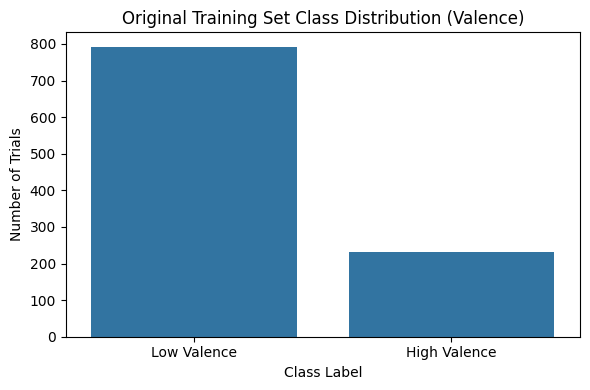


Applying SMOTE to the training data...

Training Set Class Distribution After SMOTE (Valence):
Counter({np.float64(0.0): 792, np.float64(1.0): 792})
Original training shape: (1024, 5120), Resampled shape: (1584, 5120)


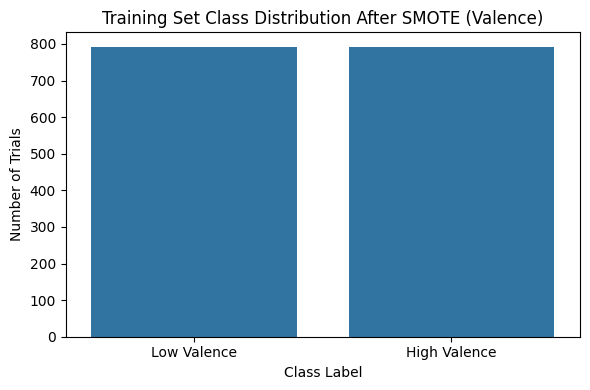

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE # Keep others commented unless needed
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# --- Use the prepared variables ---
# X_train_proc, y_train_proc are assumed available

# --- Check original class distribution for the selected task ---
print(f"Original Training Set Class Distribution ({TASK_TO_ANALYZE}):")
original_counts_deap = Counter(y_train_proc)
print(original_counts_deap)

# Define class names for binary task (Low/High Valence/Arousal)
class_names_deap = [f'Low {TASK_TO_ANALYZE}' if i == 0 else f'High {TASK_TO_ANALYZE}' for i in sorted(original_counts_deap.keys())]

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_proc, order=sorted(original_counts_deap.keys()))
plt.title(f'Original Training Set Class Distribution ({TASK_TO_ANALYZE})')
plt.xlabel('Class Label')
plt.ylabel('Number of Trials')
plt.xticks(ticks=sorted(original_counts_deap.keys()), labels=class_names_deap)
plt.tight_layout()
plt.show()

# --- Apply SMOTE (Synthetic Minority Over-sampling Technique) ---
print("\nApplying SMOTE to the training data...")
try:
    # Ensure X_train_proc is C-contiguous
    X_train_proc_contiguous = np.ascontiguousarray(X_train_proc)

    # Adjust k_neighbors based on smallest class size, ensure it's at least 1
    min_class_size = min(original_counts_deap.values()) if original_counts_deap else 0
    k_neighbors_smote = max(1, min(5, min_class_size - 1)) if min_class_size > 1 else 1

    smote_deap = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
    X_train_smote_deap, y_train_smote_deap = smote_deap.fit_resample(X_train_proc_contiguous, y_train_proc)

    print(f"\nTraining Set Class Distribution After SMOTE ({TASK_TO_ANALYZE}):")
    smote_counts_deap = Counter(y_train_smote_deap)
    print(smote_counts_deap)
    print(f"Original training shape: {X_train_proc.shape}, Resampled shape: {X_train_smote_deap.shape}")

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train_smote_deap, order=sorted(smote_counts_deap.keys()))
    plt.title(f'Training Set Class Distribution After SMOTE ({TASK_TO_ANALYZE})')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Trials')
    plt.xticks(ticks=sorted(smote_counts_deap.keys()), labels=class_names_deap)
    plt.tight_layout()
    plt.show()

    # IMPORTANT: For subsequent model training/selection, use X_train_smote_deap and y_train_smote_deap
    # instead of X_train_proc and y_train_proc. The test set remains X_test_proc, y_test_proc.

except ValueError as e:
    print(f"\nError during SMOTE: {e}")
    print("Smallest class size might be too small for default k_neighbors. Check 'original_counts_deap'.")
    print("Skipping SMOTE application.")
    # Assign original data if SMOTE failed, so subsequent cells don't break
    X_train_smote_deap, y_train_smote_deap = X_train_proc, y_train_proc

## Feature Selection Strategies (DEAP - CWT Example)

Using SMOTE-balanced data for fitting feature selectors.

--- Applying SelectKBest (k=128) ---
Selected top 128 features using SelectKBest. Example: ['F33', 'F34', 'F35', 'F36', 'F901', 'F980', 'F1171', 'F1172', 'F1173', 'F1174']
Shape after SelectKBest: Train=(1584, 128), Test=(256, 128)


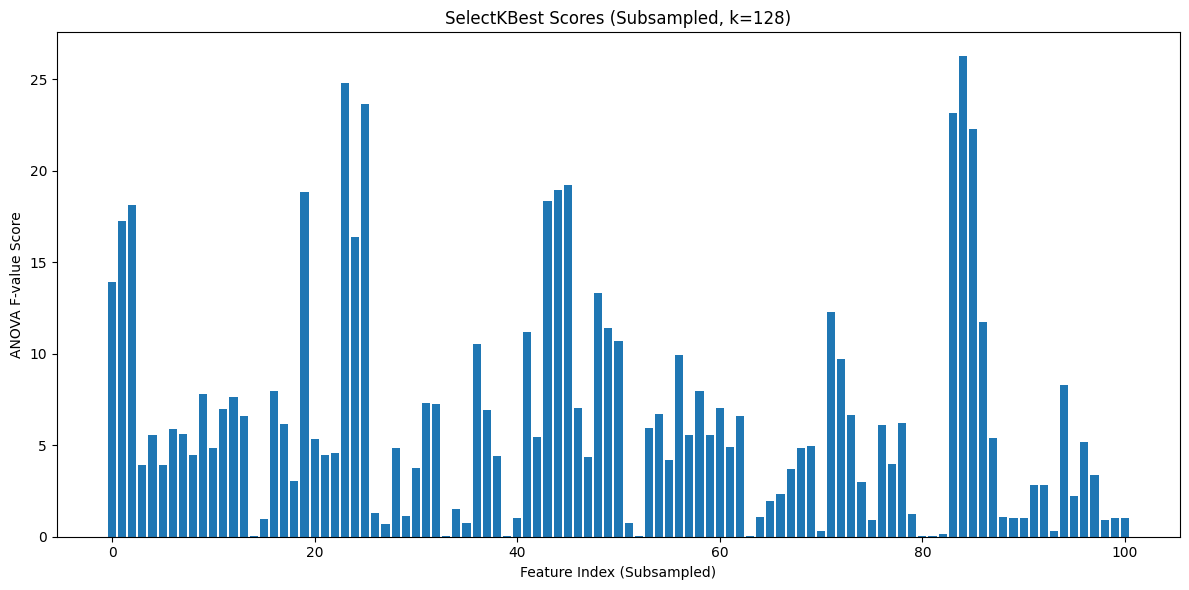


--- Using Embedded Method (Random Forest Feature Importance) ---
Training RandomForestClassifier for feature importances (this might take time)...

Top 10 Features (Random Forest Importance):
1. Feature F2380 (0.0034)
2. Feature F3669 (0.0033)
3. Feature F3587 (0.0027)
4. Feature F3617 (0.0026)
5. Feature F2307 (0.0023)
6. Feature F3659 (0.0022)
7. Feature F2378 (0.0022)
8. Feature F3630 (0.0021)
9. Feature F1288 (0.0021)
10. Feature F1215 (0.0020)


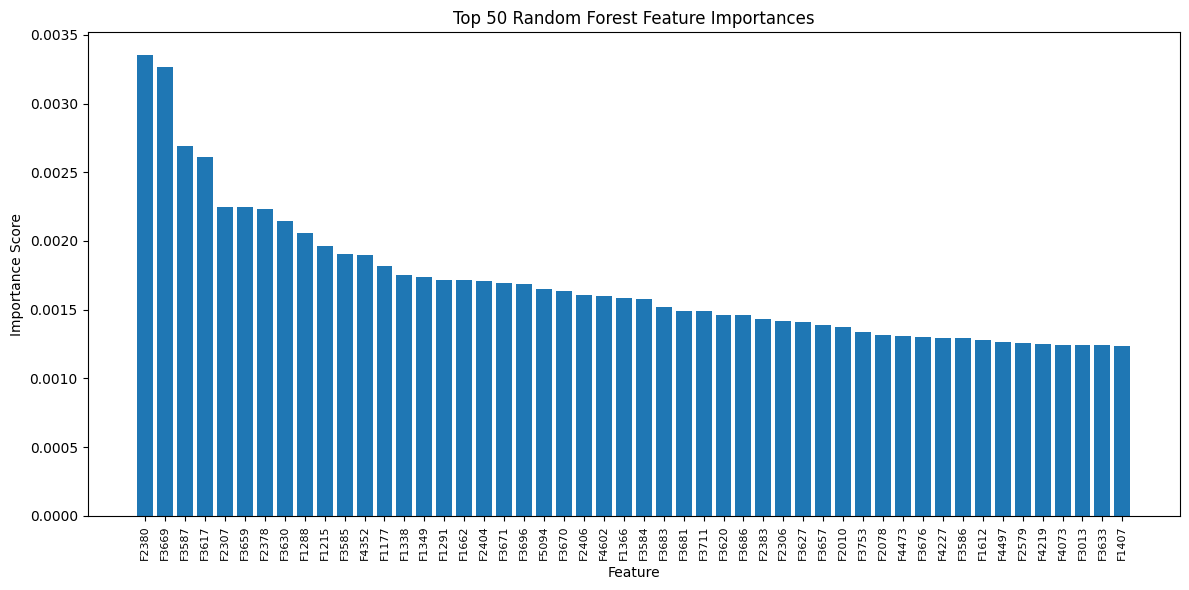


Applying SelectFromModel based on RF importance...
Selected 2560 features using SelectFromModel (median threshold). Example: ['F1', 'F5', 'F6', 'F7', 'F8', 'F12', 'F16', 'F17', 'F19', 'F23']
Shape after SelectFromModel: Train=(1584, 2560), Test=(256, 2560)

--- Applying RFE (Recursive Feature Elimination) ---
Targeting 64 features.
Fitting RFE selector (step=256, this will take considerable time)...
Selected top 64 features using RFE. Example: ['F95', 'F388', 'F389', 'F456', 'F631', 'F644', 'F703', 'F722', 'F831', 'F868']
Shape after RFE: Train=(1584, 64), Test=(256, 64)

--- Alternative Feature Selection Complete (DEAP CWT Example) ---
You could now potentially train models using the selected feature subsets:
 - SelectKBest: X_train_kbest_deap ((1584, 128)), X_test_kbest_deap ((256, 128))
 - SelectFromModel (RF): X_train_sfm_deap ((1584, 2560)), X_test_sfm_deap ((256, 2560))
 - RFE: X_train_rfe_deap ((1584, 64)), X_test_rfe_deap ((256, 64))
Compare results against using all CWT featu

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Use the prepared variables ---
# X_test_proc, y_test_proc, feature_names_proc are assumed available.
# Decide whether to use original scaled data or SMOTE-balanced data for fitting selectors.

# --- Decide which training data to use for fitting selectors ---
if 'X_train_smote_deap' in locals() and X_train_smote_deap.shape[0] > X_train_proc.shape[0]:
     print("Using SMOTE-balanced data for fitting feature selectors.")
     X_train_for_select_deap = X_train_smote_deap
     y_train_for_select_deap = y_train_smote_deap
else:
     print("Using original scaled training data for fitting feature selectors.")
     X_train_for_select_deap = X_train_proc
     y_train_for_select_deap = y_train_proc

# Ensure data is contiguous if needed by selectors
X_train_for_select_deap = np.ascontiguousarray(X_train_for_select_deap)
X_test_proc_contiguous = np.ascontiguousarray(X_test_proc) # Ensure test set is also contiguous for transform


# --- Strategy 1: Filter Method (SelectKBest using ANOVA F-value) ---
# Select a reasonable number of features, e.g., 128 or 256, much less than 5120 for CWT
k_best_features_deap = 128
print(f"\n--- Applying SelectKBest (k={k_best_features_deap}) ---")

if k_best_features_deap <= 0 or k_best_features_deap >= X_train_for_select_deap.shape[1]:
    print(f"Warning: k={k_best_features_deap} is invalid or >= number of features ({X_train_for_select_deap.shape[1]}). Skipping SelectKBest.")
    X_train_kbest_deap = X_train_for_select_deap
    X_test_kbest_deap = X_test_proc_contiguous
    selected_kbest_indices_deap = np.arange(X_train_for_select_deap.shape[1])
else:
    try:
        selector_kbest_deap = SelectKBest(score_func=f_classif, k=k_best_features_deap)
        selector_kbest_deap.fit(X_train_for_select_deap, y_train_for_select_deap)

        selected_kbest_indices_deap = selector_kbest_deap.get_support(indices=True)
        selected_feature_names_kbest = [feature_names_proc[i] for i in selected_kbest_indices_deap]

        print(f"Selected top {k_best_features_deap} features using SelectKBest. Example: {selected_feature_names_kbest[:10]}")

        X_train_kbest_deap = selector_kbest_deap.transform(X_train_for_select_deap)
        X_test_kbest_deap = selector_kbest_deap.transform(X_test_proc_contiguous)

        print(f"Shape after SelectKBest: Train={X_train_kbest_deap.shape}, Test={X_test_kbest_deap.shape}")

        # Visualize scores (optional - plot subset if too many features)
        plt.figure(figsize=(12, 6))
        scores_subset = selector_kbest_deap.scores_[::max(1, n_features_total // 100)] # Plot approx 100 scores
        indices_subset = np.arange(n_features_total)[::max(1, n_features_total // 100)]
        plt.bar(range(len(scores_subset)), scores_subset)
        plt.xlabel('Feature Index (Subsampled)')
        plt.ylabel('ANOVA F-value Score')
        plt.title(f'SelectKBest Scores (Subsampled, k={k_best_features_deap})')
        # plt.xticks(ticks=range(len(indices_subset)), labels=[feature_names_proc[i] for i in indices_subset], rotation=90, fontsize=8) # Labels likely too dense
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during SelectKBest: {e}. Skipping.")
        X_train_kbest_deap = X_train_for_select_deap
        X_test_kbest_deap = X_test_proc_contiguous
        selected_kbest_indices_deap = np.arange(X_train_for_select_deap.shape[1])


# --- Strategy 2: Embedded Method (Feature Importance from RandomForest) ---
print("\n--- Using Embedded Method (Random Forest Feature Importance) ---")
# Train a simple RF specifically for feature importance on the potentially large feature set
print("Training RandomForestClassifier for feature importances (this might take time)...")
# Reduce complexity slightly for faster importance calculation if needed
rf_for_importance_deap = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
try:
    rf_for_importance_deap.fit(X_train_for_select_deap, y_train_for_select_deap)
    importances_deap = rf_for_importance_deap.feature_importances_
    model_to_use_importance_deap = rf_for_importance_deap
except Exception as e:
    print(f"Error training RF for importance: {e}")
    importances_deap = None
    model_to_use_importance_deap = None

if importances_deap is not None:
    indices_deap = np.argsort(importances_deap)[::-1]
    print(f"\nTop 10 Features (Random Forest Importance):")
    for f in range(min(10, n_features_total)):
        print(f"{f + 1}. Feature {feature_names_proc[indices_deap[f]]} ({importances_deap[indices_deap[f]]:.4f})")

    # Visualize top N importances
    n_plot_imp = 50
    plt.figure(figsize=(12, 6))
    plt.bar(range(min(n_plot_imp, n_features_total)), importances_deap[indices_deap][:n_plot_imp], align='center')
    plt.xticks(range(min(n_plot_imp, n_features_total)), [feature_names_proc[i] for i in indices_deap[:n_plot_imp]], rotation=90, fontsize=8)
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.title(f'Top {n_plot_imp} Random Forest Feature Importances')
    plt.tight_layout()
    plt.show()

    # --- Use SelectFromModel with the trained RF ---
    print("\nApplying SelectFromModel based on RF importance...")
    # Select features with importance greater than the median
    selector_sfm_deap = SelectFromModel(estimator=model_to_use_importance_deap, threshold='median', prefit=True)
    try:
        X_train_sfm_deap = selector_sfm_deap.transform(X_train_for_select_deap)
        X_test_sfm_deap = selector_sfm_deap.transform(X_test_proc_contiguous)
        selected_sfm_indices_deap = selector_sfm_deap.get_support(indices=True)
        selected_sfm_names_deap = [feature_names_proc[i] for i in selected_sfm_indices_deap]
        print(f"Selected {len(selected_sfm_names_deap)} features using SelectFromModel (median threshold). Example: {selected_sfm_names_deap[:10]}")
        print(f"Shape after SelectFromModel: Train={X_train_sfm_deap.shape}, Test={X_test_sfm_deap.shape}")
    except Exception as e:
        print(f"Error during SelectFromModel: {e}. Skipping.")
        X_train_sfm_deap = X_train_for_select_deap
        X_test_sfm_deap = X_test_proc_contiguous
        selected_sfm_indices_deap = np.arange(X_train_for_select_deap.shape[1])
else:
    print("Could not calculate feature importances. Skipping SelectFromModel.")
    X_train_sfm_deap = X_train_for_select_deap
    X_test_sfm_deap = X_test_proc_contiguous
    selected_sfm_indices_deap = np.arange(X_train_for_select_deap.shape[1])


# --- Strategy 3: Wrapper Method (Recursive Feature Elimination - RFE) ---
# RFE is computationally expensive, especially with many features. Use cautiously.
print(f"\n--- Applying RFE (Recursive Feature Elimination) ---")
n_features_to_select_rfe_deap = 64 # Example: Select 64 features
print(f"Targeting {n_features_to_select_rfe_deap} features.")

if n_features_to_select_rfe_deap <= 0 or n_features_to_select_rfe_deap >= X_train_for_select_deap.shape[1]:
    print(f"Warning: n_features_to_select={n_features_to_select_rfe_deap} is invalid or >= number of features. Skipping RFE.")
    X_train_rfe_deap = X_train_for_select_deap
    X_test_rfe_deap = X_test_proc_contiguous
    selected_rfe_indices_deap = np.arange(X_train_for_select_deap.shape[1])
else:
    # Using Logistic Regression (faster than SVC for RFE)
    estimator_rfe_deap = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced') # Reduced max_iter potentially
    try:
        # Increase step size to speed up if needed (e.g., step=0.1 removes 10% features each time)
        selector_rfe_deap = RFE(estimator=estimator_rfe_deap, n_features_to_select=n_features_to_select_rfe_deap, step=max(1, int(0.05 * n_features_total))) # Remove 5% each step
        print(f"Fitting RFE selector (step={selector_rfe_deap.step}, this will take considerable time)...")
        selector_rfe_deap.fit(X_train_for_select_deap, y_train_for_select_deap)

        selected_rfe_indices_deap = selector_rfe_deap.get_support(indices=True)
        selected_rfe_names_deap = [feature_names_proc[i] for i in selected_rfe_indices_deap]
        print(f"Selected top {n_features_to_select_rfe_deap} features using RFE. Example: {selected_rfe_names_deap[:10]}")
        # print(f"RFE Ranking (subset): {selector_rfe_deap.ranking_[:50]}") # Show ranking for first 50

        X_train_rfe_deap = selector_rfe_deap.transform(X_train_for_select_deap)
        X_test_rfe_deap = selector_rfe_deap.transform(X_test_proc_contiguous)
        print(f"Shape after RFE: Train={X_train_rfe_deap.shape}, Test={X_test_rfe_deap.shape}")

    except Exception as e:
        print(f"Error during RFE: {e}. Skipping.")
        X_train_rfe_deap = X_train_for_select_deap
        X_test_rfe_deap = X_test_proc_contiguous
        selected_rfe_indices_deap = np.arange(X_train_for_select_deap.shape[1])


# --- Conclusion ---
print("\n--- Alternative Feature Selection Complete (DEAP CWT Example) ---")
print("You could now potentially train models using the selected feature subsets:")
print(f" - SelectKBest: X_train_kbest_deap ({X_train_kbest_deap.shape}), X_test_kbest_deap ({X_test_kbest_deap.shape})")
print(f" - SelectFromModel (RF): X_train_sfm_deap ({X_train_sfm_deap.shape}), X_test_sfm_deap ({X_test_sfm_deap.shape})")
print(f" - RFE: X_train_rfe_deap ({X_train_rfe_deap.shape}), X_test_rfe_deap ({X_test_rfe_deap.shape})")
print(f"Compare results against using all {FEATURE_SET_TO_ANALYZE} features or the mRMR selected features.")
print("Remember to use the corresponding y_train (e.g., y_train_smote_deap or y_train_proc) and y_test_proc for training and evaluation.")

# --- Clean up (optional) ---
# del X_train_kbest_deap, X_test_kbest_deap, X_train_sfm_deap, X_test_sfm_deap, X_train_rfe_deap, X_test_rfe_deap
# del selector_kbest_deap, selector_sfm_deap, selector_rfe_deap, rf_for_importance_deap
# gc.collect() # If gc imported